
## **Stage 5 모델링의 활용 - <font color="blue">HOW</font> 어떻게 연체 정도를 예측할까?**


<img src='http://drive.google.com/uc?export=view&id=1-n-mw8t-LdKqrqfazDfSAc9dKH7Lcbzl' /><br>

## **INTRO**
지난 스테이지 **Stage 4.  EDA 기반 시각화 및 가공 - <font color="blue">WHERE</font>  어디서 연체 정도가 잘 나타날까?** 에서 변수별 특징을 파악하고, 다양한 전처리 기법을 적용해보았습니다 😀     

이번 스테이지에서는 다양한 모델링 기법을 사용하여 모델을 비교하고, 최적화할 예정입니다 😎    


먼저, 데이터를 불러오고 지금까지 진행했던 전처리 작업을 수행합니다!

In [14]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive') # 구글 드라이브를 사용하는 경우

PATH = "/content/drive/MyDrive/데이크루6기_보초석분/data/"

train = pd.read_csv(PATH+'train.csv') # pd.read_csv(PATH) -> PATH에 로컬 저장 경로 입력 ex) C:/home/data/train.csv
test = pd.read_csv(PATH+'test.csv')
submission = pd.read_csv(PATH+'sample_submission.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# 데이터 전처리 전체 코드
## 1. 결측치 처리 및 비정상 변수 삭제
train.fillna('NaN', inplace=True)
test.fillna('NaN', inplace=True)
train = train.drop('FLAG_MOBIL', axis=1)
test = test.drop('FLAG_MOBIL', axis=1)

## 2. 라벨 & 원핫 인코딩
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder()

columns_to_label = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']
columns_to_onehot = ['gender', 'car', 'reality']

for column in columns_to_label:
    train[column] = label_encoder.fit_transform(train[column])
    print(label_encoder.classes_)
    test[column] = label_encoder.transform(test[column])

for column in columns_to_onehot:
    train[column] = onehot_encoder.fit_transform(train[column].values.reshape(-1, 1)).toarray()
    print(onehot_encoder.categories_)
    test[column] = onehot_encoder.transform(test[column].values.reshape(-1, 1)).toarray()


## 3. 파생변수 생성
train['Income_Per_Family_Member'] = train['income_total'] / train['family_size']
train['Child_to_Family_Ratio'] = train['child_num'] / train['family_size']
train['Is_Working'] = train['DAYS_EMPLOYED'].apply(lambda x: 0 if x >= 0 else 1)

test['Income_Per_Family_Member'] = test['income_total'] / test['family_size']
test['Child_to_Family_Ratio'] = test['child_num'] / test['family_size']
test['Is_Working'] = test['DAYS_EMPLOYED'].apply(lambda x: 0 if x >= 0 else 1)



## 4. 이상치 처리
import numpy as np

columns_to_process = [column for column in train.columns if column != 'credit' and train[column].dtype in ['int64', 'float64']]

for column in columns_to_process:
    Q1 = train[column].quantile(0.25)
    Q3 = train[column].quantile(0.75)
    IQR = Q3 - Q1
    min_value = Q1 - 1.5 * IQR
    max_value = Q3 + 1.5 * IQR
    train[column] = np.where(train[column] < min_value, min_value, train[column])
    train[column] = np.where(train[column] > max_value, max_value, train[column])


## 4. 데이터 스케일링
continuous_features = ['child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'family_size', 'begin_month', 'Income_Per_Family_Member', 'Child_to_Family_Ratio']

selected_scalers = {}

for feature in continuous_features:
    if train[feature].skew() > 1:
        selected_scalers[feature] = 'RobustScaler'
    elif train[feature].min() >= 0:
        selected_scalers[feature] = 'MinMaxScaler'
    else:  # 특성이 정규 분포일 경우
        selected_scalers[feature] = 'StandardScaler'

print(selected_scalers)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

scaled_features = {}
for feature, scaler_name in selected_scalers.items():
    scaler = scalers[scaler_name]
    train[feature] = scaler.fit_transform(train[[feature]])
    test[feature] = scaler.transform(test[[feature]])

print(selected_scalers, scaled_features)

['Commercial associate' 'Pensioner' 'State servant' 'Student' 'Working']
['Academic degree' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Secondary / secondary special']
['Civil marriage' 'Married' 'Separated' 'Single / not married' 'Widow']
['Co-op apartment' 'House / apartment' 'Municipal apartment'
 'Office apartment' 'Rented apartment' 'With parents']
['Accountants' 'Cleaning staff' 'Cooking staff' 'Core staff' 'Drivers'
 'HR staff' 'High skill tech staff' 'IT staff' 'Laborers'
 'Low-skill Laborers' 'Managers' 'Medicine staff' 'NaN'
 'Private service staff' 'Realty agents' 'Sales staff' 'Secretaries'
 'Security staff' 'Waiters/barmen staff']
[array(['F', 'M'], dtype=object)]
[array(['N', 'Y'], dtype=object)]
[array(['N', 'Y'], dtype=object)]
{'child_num': 'RobustScaler', 'income_total': 'MinMaxScaler', 'DAYS_BIRTH': 'StandardScaler', 'DAYS_EMPLOYED': 'StandardScaler', 'family_size': 'MinMaxScaler', 'begin_month': 'StandardScaler', 'Income_Per_Family_Member': 'MinMaxSca

### **1. 통계 모델**

다중공선성은 여러 회귀 모델의 두 개 이상의 예측 변수가 매우 상관 관계가 있어서 하나가 다른 것으로부터 상당한 정확도로 선형적으로 예측될 수 있는 상황을 나타냅니다.

Variance Inflation Factor (VIF)를 사용하여 다중공선성을 확인합니다. VIF 값이 10보다 크면 다중공선성이 높다고 볼 수 있습니다.

    
##### **Inst.**
statsmodels 라이브러리의 outliers_influence 모듈에서 variance_inflation_factor 함수는 각 변수의 VIF 값을 계산하는 데 사용됩니다.   
직접 VIF를 구해볼까요? 🤗

1. VIF를 저장할 데이터 프레임 초기화
2. 변수 이름 설정
3. VIF 계산
- 리스트 내포를 사용하여 train 데이터 프레임의 각 열(변수)에 대한 VIF 값을 계산합니다.
- variance_inflation_factor(train.values, i)는 train 데이터 프레임의 i번째 열의 VIF 값을 반환합니다.
- range(train.shape[1])는 train 데이터 프레임의 열 수만큼의 범위를 생성합니다.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. VIF를 저장할 데이터 프레임 초기화

# 2. 변수 이름 설정

# 3. VIF 계산


##### **Hint.**
```python
variance_inflation_factor(exog, exog_idx)
```

- **exog**: array-like
   - 독립 변수들의 데이터셋입니다. 이 데이터셋에서 특정 한 변수를 대상으로 VIF를 계산할 때 나머지 변수들을 사용하여 회귀분석을 수행합니다.
   - 예를 들어, 여러 변수 중에서 특정 한 변수의 VIF를 계산하려면, 해당 변수를 종속 변수로 설정하고 나머지 변수들을 독립 변수로 사용하여 회귀분석을 합니다.

- **exog_idx**: int
   - VIF를 계산하려는 변수의 인덱스입니다. `exog` 데이터셋에서 이 인덱스에 해당하는 변수에 대한 VIF 값을 계산합니다.

- **반환 값**
    - 해당 변수의 VIF 값입니다. VIF 값이 10 이상이면 해당 변수는 다른 변수들과 높은 상관관계를 가지며, 다중공선성이 높다고 판단될 수 있습니다.


##### **Solution.**



In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. VIF를 저장할 데이터 프레임 초기화
vif_data = pd.DataFrame()

# 2. 변수 이름 설정
vif_data["Variable"] = train.columns

# 3. VIF 계산
vif_data["VIF"] = [variance_inflation_factor(train.values, i) for i in range(train.shape[1])]

print(vif_data)

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                    Variable        VIF
0                      index   1.000684
1                     gender   1.243236
2                        car   1.221044
3                    reality   1.031722
4                  child_num  44.477863
5               income_total   9.056651
6                income_type   1.159679
7                   edu_type   1.110408
8                family_type   0.000000
9                 house_type   0.000000
10                DAYS_BIRTH   1.404995
11             DAYS_EMPLOYED   1.325880
12                work_phone        NaN
13                     phone   1.011304
14                     email        NaN
15                occyp_type   1.096611
16               family_size  23.381878
17               begin_month   1.036209
18                    credit   1.023632
19  Income_Per_Family_Member  15.490910
20     Child_to_Family_Ratio  23.451604
21                Is_Working   0.000000


VIF가 10보다 큰 변수를 제외합니다.

In [17]:
vif_data[vif_data["VIF"] > 10]

,Variable,VIF
4,child_num,44.477863
16,family_size,23.381878
19,Income_Per_Family_Member,15.490910
20,Child_to_Family_Ratio,23.451604


In [18]:
train = train.drop(vif_data[vif_data["VIF"] > 10]['Variable'].tolist(), axis=1)
test= test.drop(vif_data[vif_data["VIF"] > 10]['Variable'].tolist(), axis=1)

In [19]:
train.head()

,index,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,begin_month,credit,Is_Working
0,0.0,1.0,1.0,1.0,0.496815,0.0,1.0,1.0,1.0,0.490075,-1.095124,0.0,0.0,0.0,12.0,1.215231,1.0,1.0
1,1.0,1.0,1.0,0.0,0.624204,0.0,4.0,1.0,1.0,1.089621,-0.022318,0.0,0.0,0.0,8.0,1.275620,1.0,1.0
2,2.0,0.0,0.0,0.0,1.000000,4.0,1.0,1.0,1.0,-0.744719,-1.002028,0.0,1.0,0.0,10.0,0.249003,2.0,1.0
3,3.0,1.0,1.0,0.0,0.496815,0.0,4.0,1.0,1.0,0.207081,-0.209187,0.0,1.0,0.0,15.0,-0.656836,0.0,1.0
4,4.0,1.0,0.0,0.0,0.369427,2.0,1.0,1.0,1.0,0.219220,-0.213588,0.0,0.0,0.0,10.0,0.007446,2.0,1.0


In [20]:
from sklearn.model_selection import train_test_split

X = train.drop(['index', 'credit'], axis=1)
y = train[['credit']]

# 1. train_test_split()을 이용하여 데이터를 분리합니다. (단, test_size는 0.2, random_state는 42로 설정합니다)
train_X, test_X, train_Y, test_Y = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)

print(train_X.shape, test_X.shape, train_Y.shape, test_Y.shape)

(21165, 16) (5292, 16) (21165, 1) (5292, 1)


다시 Stage 1에서 사용했던, 다중 로지스틱 회귀를 사용해봅시다!

In [26]:
from sklearn.linear_model import LogisticRegression

# 1. lrmodel 변수에 로지스틱 회귀 모델을 선언합니다.
lrmodel = LogisticRegression()

# 2. lrmodel에 train_X, train_Y를 fit 합니다.
lrmodel.fit(train_X, train_Y)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [31]:
# log_loss 성능평가 계산을 위한 라이브러리
from sklearn.metrics import log_loss
print(log_loss(train_Y, lrmodel.predict_proba(train_X,)))
print(log_loss(test_Y, lrmodel.predict_proba(test_X)))

0.8617009932292691
0.863275489075871


Stage 1에서 log_loss 점수는 0.87이었는데, 0.86으로 성능이 더 좋아졌군요 😀

### **2. 머신러닝 모델**

머신러닝 모델로는 RandomForest, XGBoost 등 다양한 모델이 있습니다.

여기서는 다음 9가지 모델로 학습을 진행합니다.

1. **DecisionTree (결정 트리)**:
   - 결정 트리는 특성을 기반으로 데이터를 분류하는 트리 구조의 알고리즘입니다.
   - 각 노드에서는 특정 특성의 임계값을 기준으로 데이터를 분할하며, 리프 노드에서는 최종 예측 값을 반환합니다.

2. **RandomForest (랜덤 포레스트)**:
   - 여러 개의 결정 트리를 학습하여 그 결과를 평균내어 예측하는 앙상블 방법입니다.
   - 각 트리는 부트스트랩 샘플을 사용하여 학습되며, 특성 선택도 무작위로 이루어집니다.

3. **SVM (Support Vector Machine)**:
   - 데이터를 분류하기 위해 최적의 초평면을 찾는 알고리즘입니다.
   - SVM은 마진을 최대화하여 두 클래스를 분리합니다.

4. **LogisticRegression (로지스틱 회귀)**:
   - 로지스틱 함수를 사용하여 확률을 예측하는 회귀 알고리즘입니다.
   - 이진 분류 또는 다중 분류에 사용될 수 있습니다.

5. **NaiveBayes (나이브 베이즈)**:
   - 베이즈 정리를 기반으로 한 확률적 분류 알고리즘입니다.
   - 각 특성이 독립적이라는 가정을 기반으로 합니다.

6. **KNeighbors (K-최근접 이웃)**:
   - 새로운 데이터 포인트의 클래스를 결정하기 위해 가장 가까운 K개의 훈련 데이터 포인트를 참조하는 알고리즘입니다.

7. **XGBoost**:
   - 그래디언트 부스팅 알고리즘을 기반으로 한 앙상블 학습 방법입니다.
   - 여러 개의 약한 학습기를 결합하여 강력한 모델을 생성합니다.

8. **LightGBM**:
   - XGBoost와 유사하게 그래디언트 부스팅 알고리즘을 기반으로 하지만, 더 빠르고 메모리 효율적입니다.
   - 대량의 데이터셋에 효과적입니다.

9. **ExtraTrees (익스트림 랜덤 트리)**:
   - 랜덤 포레스트와 유사하지만, 트리를 더욱 무작위하게 생성하는 방법입니다.
   - 각 노드에서의 분할은 무작위로 선택된 특성에 대해 최적의 임계값을 찾는 대신, 무작위 임계값을 사용합니다.

이러한 모델들은 다양한 데이터셋과 문제에 대해 다양한 성능을 보일 수 있으므로, 특정 문제에 가장 적합한 모델을 선택하는 것이 중요합니다.

먼저, 필요한 라이브러리를 불러옵니다.

In [33]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import xgboost as xgb
import lightgbm as lgb

편리한 학습을 위해 ClassificationModelWrapper 클래스를 선언하여, 다양한 모델의 성능을 평가해볼까요?

- **ClassificationModelWrapper 클래스**:
   - 이 클래스는 다양한 분류 모델을 래핑하여 사용하기 쉽게 만들어줍니다.
   - `__init__` 메서드에서는 모델의 유형을 초기화합니다.
   - `fit` 메서드에서는 지정된 모델 유형에 따라 해당 모델을 초기화하고, 학습 데이터를 사용하여 모델을 학습시킵니다.
   - `predict` 메서드에서는 테스트 데이터를 사용하여 예측을 수행하고, 예측 확률을 반환합니다.


In [34]:
class ClassificationModelWrapper:
    def __init__(self, model_type):
        self.model_type = model_type
        self.model = None

    def fit(self, train_X, train_Y):
        if self.model_type == 'DecisionTree':
            self.model = DecisionTreeClassifier(random_state=42)
        elif self.model_type == 'RandomForest':
            self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        elif self.model_type == 'SVM':
            self.model = SVC(random_state=42, probability=True)
        elif self.model_type == 'LogisticRegression':
            self.model = LogisticRegression(max_iter=1000, random_state=42)
        elif self.model_type == 'NaiveBayes':
            self.model = GaussianNB()
        elif self.model_type == 'KNeighbors':
            self.model = KNeighborsClassifier()
        elif self.model_type == 'XGBoost':
            self.model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=6, random_state=42)
        elif self.model_type == 'LightGBM':
            self.model = lgb.LGBMClassifier(learning_rate=0.1, n_estimators=100, random_state=42, force_col_wise=True)
        elif self.model_type == 'ExtraTrees':
            self.model = ExtraTreesClassifier(n_estimators=100, random_state=42)

        self.model.fit(train_X, train_Y)

    def predict(self, X_test):
        return self.model.predict_proba(X_test)

각 모델에 대해 학습을 진행합니다.

In [35]:
model_types = ['DecisionTree', 'RandomForest', 'SVM', 'LogisticRegression', 'NaiveBayes', 'KNeighbors', 'XGBoost', 'LightGBM', 'ExtraTrees']

for model_type in model_types:
    print(f"Model: {model_type}")
    ml_model = ClassificationModelWrapper(model_type=model_type)
    ml_model.fit(train_X, train_Y.values.ravel())
    ml_predictions = ml_model.predict(test_X)

    logloss = log_loss(test_Y.values.ravel(), ml_predictions)
    print("Log loss:", logloss)

Model: DecisionTree
Log loss: 13.809429634679027
Model: RandomForest
Log loss: 0.941676275124791
Model: SVM
Log loss: 0.8301461087996502
Model: LogisticRegression
Log loss: 0.8632957011034909
Model: NaiveBayes
Log loss: 0.8571510342474584
Model: KNeighbors
Log loss: 4.19296204126311
Model: XGBoost
Log loss: 0.7728087736574312
Model: LightGBM
[LightGBM] [Info] Total Bins 753
[LightGBM] [Info] Number of data points in the train set: 21165, number of used features: 11
[LightGBM] [Info] Start training from score -2.105335
[LightGBM] [Info] Start training from score -1.440314
[LightGBM] [Info] Start training from score -0.444193
Log loss: 0.7611246140225514
Model: ExtraTrees
Log loss: 2.4569329592681934


### **3. 딥러닝 모델**

딥러닝은 인공 신경망을 기반으로 한 머신러닝의 하위 분야입니다. 인공 신경망은 뉴런이라는 기본 단위를 사용하여 복잡한 패턴을 학습하고 예측합니다. 딥러닝 모델은 여러 개의 은닉층을 포함하여 깊은 네트워크를 형성하며, 이를 통해 복잡한 패턴과 관계를 학습할 수 있습니다.

여기서는 Keras와 Scikit-learn의 MLPClassifier를 활용하여 딥러닝 모델을 실행해봅니다.

먼저, 필요한 라이브러리를 불러옵니다.


In [36]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.neural_network import MLPClassifier
import random
import tensorflow as tf
import os
seed_value = 42

- DeepLearningModelWrapper 클래스: 딥러닝 모델을 래핑하여 사용하기 쉽게 만들어줍니다.
    - __init__ 메서드:
        - 모델의 유형을 초기화합니다.
    - fit 메서드:
        - 지정된 모델 유형에 따라 모델을 학습시킵니다.
        - Keras: Keras 라이브러리를 사용하여 인공 신경망 모델을 생성하고 학습시킵니다.
        - MLP: Scikit-learn의 MLPClassifier를 사용하여 다층 퍼셉트론 모델을 학습시킵니다.
    - predict 메서드
        - 테스트 데이터를 사용하여 예측을 수행하고 결과를 반환합니다.
    - _create_keras_model 메서드:
        - Keras를 사용하여 인공 신경망 모델을 생성합니다.
        - Sequential 모델은 레이어를 순차적으로 쌓아 구성합니다.
        - Dense 레이어는 완전 연결 레이어로, 각 뉴런이 이전 레이어의 모든 뉴런과 연결되어 있습니다.
        - categorical_crossentropy는 다중 클래스 분류 문제의 손실 함수로 사용됩니다.
        - softmax 활성화 함수는 출력 레이어에서 클래스 확률을 반환하기 위해 사용됩니다.

In [37]:
# 재현성을 위한 시드 값 설정
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 다양한 라이브러리의 랜덤 연산을 위한 시드 값 설정
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

class DeepLearningModelWrapper:
    def __init__(self, model_type):
        # 모델 유형 초기화 (예: 'Keras', 'MLP')
        self.model_type = model_type
        # 모델 객체 초기화
        self.model = None

    def fit(self, train_X, train_Y):
        # Keras 모델을 사용하는 경우
        if self.model_type == 'Keras':
            # Keras 모델 생성
            self.model = self._create_keras_model(train_X.shape[1], len(np.unique(train_Y)))
            # 레이블을 원-핫 인코딩 형식으로 변환
            y_train_encoded = to_categorical(train_Y)
            # 모델 학습
            self.model.fit(train_X, y_train_encoded, epochs=50, batch_size=32, verbose=0)
        # MLP 모델을 사용하는 경우
        elif self.model_type == 'MLP':
            # MLP 모델 생성 및 학습
            self.model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=1000, random_state=42)
            self.model.fit(train_X, train_Y)

    def predict(self, test_X):
        # Keras 모델을 사용하여 예측하는 경우
        if self.model_type == 'Keras':
            predictions = self.model.predict(test_X)
            return predictions
        # MLP 모델을 사용하여 예측하는 경우
        elif self.model_type == 'MLP':
            return self.model.predict_proba(test_X)

    def _create_keras_model(self, input_dim, output_dim):
        # Keras 라이브러리 임포트
        from keras.models import Sequential
        from keras.layers import Dense

        # 순차 모델 생성
        model = Sequential()
        # 첫 번째 은닉층 추가 (64개의 뉴런, ReLU 활성화 함수 사용)
        model.add(Dense(64, input_dim=input_dim, activation='relu'))
        # 두 번째 은닉층 추가 (32개의 뉴런, ReLU 활성화 함수 사용)
        model.add(Dense(32, activation='relu'))
        # 출력층 추가 (소프트맥스 활성화 함수 사용)
        model.add(Dense(output_dim, activation='softmax'))
        # 모델 컴파일 (손실 함수로 범주형 크로스 엔트로피 사용, 옵티마이저로 아담 사용)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

In [38]:
# 사용할 딥러닝 모델 유형 리스트
model_types = ['Keras', 'MLP']

# 각 모델 유형에 대해 반복
for model_type in model_types:
    print(f"Model: {model_type}")
    dl_model = DeepLearningModelWrapper(model_type=model_type)
    dl_model.fit(train_X, train_Y.values.ravel())
    dl_predictions = dl_model.predict(test_X)

    logloss = log_loss(test_Y.values.ravel(), dl_predictions)
    print(f"Logloss: {logloss}")
    print()

Model: Keras
166/166 [==============================] - 1s 3ms/step
Logloss: 0.8135493519064946

Model: MLP
Logloss: 0.8427020714220524



### **4. 최적 모델 선택 및 하이퍼파라미터 최적화**
머신러닝 모델 중 LightGBM이 가장 높은 성능을 보여주는 것을 확인했습니다!    
최적 LightGBM을 구할 수 있도록 학습해봅시다 😎
모델 최적화를 위해 하이퍼파라미터 튜닝에 사용하는 Automl 라이브러리인 Qptuna를 사용하겠습니다.

Optuna 라이브러리를 먼저 설치해줍니다.

In [39]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.1 MB/s eta 0:00:00


optuna와 함께 Light GBM, 성능평가, 도구 라이브러리를 임포트합니다.

In [48]:
import optuna

# 머신러닝 모델 학습 관련 라이브러리
from lightgbm import LGBMClassifier
from lightgbm import early_stopping

# log_loss 성능평가 계산을 위한 라이브러리
from sklearn.metrics import log_loss

# 프로그램 진행상황을 그림으로 볼 수 있게 해주는 파이썬 라이브러리
from tqdm import tqdm
from optuna import Trial
from optuna.samplers import TPESampler

In [67]:
def objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "objective": "multiclass",
        "metric": "multi_logloss",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    model = LGBMClassifier(**params_lgb)
    model.fit(
        X_train,
        y_train.values.ravel(),
        eval_set=[(X_valid, y_valid.values.ravel())],
        eval_metric='logloss',
        callbacks=[early_stopping(stopping_rounds=100)]
    )

    lgb_pred = model.predict_proba(X_valid)
    log_score = log_loss(y_valid, lgb_pred)

    return log_score

light GBM 을 param으로 지정한 하이퍼 파라미터에 따라 튜닝을 진행해볼까요?    
시간상 optimize()의 n_trials=10으로 설정했는데요,   
더 많은 튜닝을 수행하고 싶으시면, 시행 횟수인 n_trials을 늘리시면 됩니다!

In [68]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)

study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-30 14:51:49,158] A new study created in memory with name: lgbm_parameter_opt


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[533]	valid_0's multi_logloss: 0.754609


[I 2023-08-30 14:52:03,000] Trial 0 finished with value: 0.7546090797807997 and parameters: {'reg_alpha': 1.12424581642324e-05, 'reg_lambda': 0.08556428806974939, 'max_depth': 15, 'num_leaves': 154, 'colsample_bytree': 0.4936111842654619, 'subsample': 0.40919616423534183, 'subsample_freq': 1, 'min_child_samples': 88, 'max_bin': 380}. Best is trial 0 with value: 0.7546090797807997.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	valid_0's multi_logloss: 0.74134


[I 2023-08-30 14:52:14,043] Trial 1 finished with value: 0.7413403480462297 and parameters: {'reg_alpha': 2.1245096608103405e-05, 'reg_lambda': 0.0018526142807772773, 'max_depth': 20, 'num_leaves': 214, 'colsample_bytree': 0.5274034664069657, 'subsample': 0.42727747704497043, 'subsample_freq': 2, 'min_child_samples': 34, 'max_bin': 357}. Best is trial 1 with value: 0.7413403480462297.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[625]	valid_0's multi_logloss: 0.756991


[I 2023-08-30 14:52:24,717] Trial 2 finished with value: 0.7569913616134298 and parameters: {'reg_alpha': 1.2964031109077052e-05, 'reg_lambda': 0.02621062970553237, 'max_depth': 13, 'num_leaves': 37, 'colsample_bytree': 0.5752867891211308, 'subsample': 0.5564532903055841, 'subsample_freq': 5, 'min_child_samples': 80, 'max_bin': 260}. Best is trial 1 with value: 0.7413403480462297.


Training until validation scores don't improve for 100 rounds


[I 2023-08-30 14:52:27,145] Trial 3 finished with value: 0.8034447018826231 and parameters: {'reg_alpha': 1.5431890808024213e-05, 'reg_lambda': 0.05331731527343814, 'max_depth': 1, 'num_leaves': 156, 'colsample_bytree': 0.502314474212375, 'subsample': 0.3455361150896956, 'subsample_freq': 10, 'min_child_samples': 97, 'max_bin': 443}. Best is trial 1 with value: 0.7413403480462297.


Early stopping, best iteration is:
[230]	valid_0's multi_logloss: 0.803445
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[308]	valid_0's multi_logloss: 0.750833


[I 2023-08-30 14:52:35,138] Trial 4 finished with value: 0.7508328966065709 and parameters: {'reg_alpha': 9.145366937509386e-06, 'reg_lambda': 0.008790499283853408, 'max_depth': 14, 'num_leaves': 114, 'colsample_bytree': 0.47322294090686734, 'subsample': 0.6466238370778892, 'subsample_freq': 1, 'min_child_samples': 92, 'max_bin': 277}. Best is trial 1 with value: 0.7413403480462297.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[524]	valid_0's multi_logloss: 0.750366


[I 2023-08-30 14:52:59,684] Trial 5 finished with value: 0.7503655020012663 and parameters: {'reg_alpha': 1.987904330777592e-05, 'reg_lambda': 0.028054003730936226, 'max_depth': 11, 'num_leaves': 141, 'colsample_bytree': 0.5109126733153162, 'subsample': 0.9787092394351908, 'subsample_freq': 8, 'min_child_samples': 95, 'max_bin': 469}. Best is trial 1 with value: 0.7413403480462297.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[696]	valid_0's multi_logloss: 0.793801


[I 2023-08-30 14:53:08,821] Trial 6 finished with value: 0.7938011522180135 and parameters: {'reg_alpha': 1.7941020364544445e-05, 'reg_lambda': 0.08296868193333816, 'max_depth': 2, 'num_leaves': 51, 'colsample_bytree': 0.4271363733463229, 'subsample': 0.527731231534285, 'subsample_freq': 4, 'min_child_samples': 31, 'max_bin': 449}. Best is trial 1 with value: 0.7413403480462297.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[401]	valid_0's multi_logloss: 0.774228


[I 2023-08-30 14:53:25,803] Trial 7 finished with value: 0.7742282252104071 and parameters: {'reg_alpha': 1.0709032267540741e-05, 'reg_lambda': 0.025284113062519174, 'max_depth': 11, 'num_leaves': 37, 'colsample_bytree': 0.8813181884524238, 'subsample': 0.35218545057583955, 'subsample_freq': 10, 'min_child_samples': 79, 'max_bin': 259}. Best is trial 1 with value: 0.7413403480462297.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[105]	valid_0's multi_logloss: 0.750894


[I 2023-08-30 14:53:35,044] Trial 8 finished with value: 0.7508943138187134 and parameters: {'reg_alpha': 1.7560829253683595e-07, 'reg_lambda': 0.07339153040632079, 'max_depth': 15, 'num_leaves': 187, 'colsample_bytree': 0.8627622080115674, 'subsample': 0.35183125621386324, 'subsample_freq': 4, 'min_child_samples': 16, 'max_bin': 459}. Best is trial 1 with value: 0.7413403480462297.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1218]	valid_0's multi_logloss: 0.791503


[I 2023-08-30 14:53:45,479] Trial 9 finished with value: 0.7915032981719455 and parameters: {'reg_alpha': 1.8702710823558463e-05, 'reg_lambda': 0.02978082892775818, 'max_depth': 2, 'num_leaves': 81, 'colsample_bytree': 0.5951099932160482, 'subsample': 0.8107243248366449, 'subsample_freq': 7, 'min_child_samples': 90, 'max_bin': 342}. Best is trial 1 with value: 0.7413403480462297.


Best Score: 0.7413403480462297
Best trial: {'reg_alpha': 2.1245096608103405e-05, 'reg_lambda': 0.0018526142807772773, 'max_depth': 20, 'num_leaves': 214, 'colsample_bytree': 0.5274034664069657, 'subsample': 0.42727747704497043, 'subsample_freq': 2, 'min_child_samples': 34, 'max_bin': 357}


best_trial로 학습 최적모델을 불러와볼게요!
best_trial.params로 최적모델의 하이퍼 파라미터를 불러올 수 있습니다.

In [69]:
trial = study.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 0.7413403480462297,
params {'reg_alpha': 2.1245096608103405e-05, 'reg_lambda': 0.0018526142807772773, 'max_depth': 20, 'num_leaves': 214, 'colsample_bytree': 0.5274034664069657, 'subsample': 0.42727747704497043, 'subsample_freq': 2, 'min_child_samples': 34, 'max_bin': 357}


In [ ]:
# trial_params = {'reg_alpha': 2.1245096608103405e-05, 'reg_lambda': 0.0018526142807772773, 'max_depth': 20, 'num_leaves': 214, 'colsample_bytree': 0.5274034664069657, 'subsample': 0.42727747704497043, 'subsample_freq': 2, 'min_child_samples': 34, 'max_bin': 357}

log loss 점수는 0.74 였고, 하이퍼파라미터는 깊이 20 등으로 나타나네요!   

아래 메서드로 최적 모델 선택 과정을 시각화할 수 있습니다.

In [76]:
optuna.visualization.plot_optimization_history(study)

In [77]:
optuna.visualization.plot_parallel_coordinate(study)

In [78]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

최적 하이퍼파라미터로 최종 모델을 다시 학습시켜봅시다~     
LGBMRegressor()으로 모델을 선언하고, fit() 함수로 학습을 진행할 수 있어요!   

In [70]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [89]:
final_lgb_model = lgb.LGBMClassifier(**trial_params, verbosity=-1)
final_lgb_model.fit(
        X_train,
        y_train.values.ravel(),
        eval_set=[(X_valid, y_valid.values.ravel())],
        eval_metric='logloss',
        callbacks=[early_stopping(stopping_rounds=100)]
    )

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[74]	valid_0's multi_logloss: 0.749245


LGBMClassifier(colsample_bytree=0.5274034664069657, max_bin=357, max_depth=20,
               min_child_samples=34, num_leaves=214,
               reg_alpha=2.1245096608103405e-05,
               reg_lambda=0.0018526142807772773, subsample=0.42727747704497043,
               subsample_freq=2, verbosity=-1)

feature_importances_로 학습한 모델의 변수 중요도를 살펴볼 수 있습니다!

<BarContainer object of 16 artists>

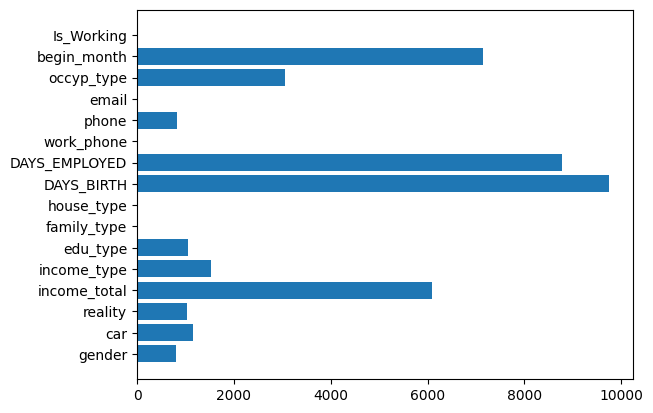

In [90]:
import matplotlib.pyplot as plt

plt.barh(train_X.columns, final_lgb_model.feature_importances_)

학습한 모델이 날아가버리면 안되겠죠?   
joblib 라이브러리로 학습한 모델을 저장할 수 있습니다!

모델을 저장하기 위해 joblib 라이브러리를 임포트해봅시다.

In [97]:
import joblib

dump() 함수로 모델과 저장 경로를 지정할 수 있습니다.

In [99]:
# 모델 저장
joblib.dump(final_lgb_model, '/content/drive/MyDrive/데이크루6기_보초석분/lgb_final_model.pkl')

['/content/drive/MyDrive/대외활동/데이크루6기_보초석분/lgb_final_model.pkl']

load() 함수로 모델을 다시 불러와서 예측할 수 있답니다 😋

In [100]:
# 모델 불러오기
load_model = joblib.load('/content/drive/MyDrive/데이크루6기_보초석분/lgb_final_model.pkl')

predict_proba() 함수로 테스트 데이터 예측을 수행하고, 제출해볼까요?

In [91]:
pred = final_lgb_model.predict_proba(test.drop(['index'], axis=1))

In [93]:
submission.loc[:, 1:] = pred

<ipython-input-93-45efe83f3ec8>:1: FutureWarning:

Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.



In [94]:
submission

,index,0,1,2
0,26457,0.423534,0.523692,0.052774
1,26458,0.282488,0.676867,0.040645
2,26459,0.315898,0.628593,0.055509
3,26460,0.302833,0.643667,0.053500
4,26461,0.135161,0.820607,0.044232
...,...,...,...,...
9995,36452,0.308257,0.652423,0.039320
9996,36453,0.554998,0.427504,0.017498
9997,36454,0.299639,0.656250,0.044111
9998,36455,0.173577,0.796008,0.030416


In [96]:
submission.to_csv(PATH+'lgb_optuna_submission.csv', index=False)

신용카드 사용자 연체를 예측하는 최적 모델을 얻으셨군요! 휼륭합니다~

<img src='http://drive.google.com/uc?export=view&id=1MAB-YSVPW8c7F0zBxVyZE3jXB0k-jq6z' /><br>

Stage 5까지 오시느라 고생 많으셨습니다! 마지막 스테이지에서 다시 만나요 ✋